In [18]:
import os
import json
import matplotlib.pyplot as plt


In [19]:

# Base directory containing all results
n1_dir = f'1n_gateway_results_1000bs'
n2_dir = f'2n_gateway_results_1000bs'
n4_dir = f'4n_gateway_results_1000bs'
n8_dir = f'8n_gateway_results_1000bs'
n10_dir = f'10n_gateway_results_1000bs'
n16_dir = f'16n_gateway_results_1000bs'

In [20]:
# Helper to convert bytes into readable KB/MB/GB
def format_bytes(num_bytes):
    if num_bytes >= 1024 ** 3:
        return f"{num_bytes / (1024 ** 3):.1f} GB"
    elif num_bytes >= 1024 ** 2:
        return f"{num_bytes / (1024 ** 2):.1f} MB"
    elif num_bytes >= 1024:
        return f"{num_bytes / 1024:.1f} KB"
    else:
        return f"{num_bytes} B"

# Helper function to plot bandwidth and IOPS with color per xfersize
def plot_with_xfersize(ax_bw, ax_iops, data, title, color_map):
    if not data:
        return

    unique_xfersizes = sorted(set(xfersize for _, _, xfersize, _ in data))
    colors = plt.cm.tab10.colors
    xfersize_to_color = {xf: colors[i % len(colors)] for i, xf in enumerate(unique_xfersizes)}

    for xf in unique_xfersizes:
        xs = [t for t, _, x, _ in data if x == xf]
        ys_bw = [b for _, b, x, _ in data if x == xf]
        ys_iops = [i for _, _, x, i in data if x == xf]
        label = f'xfersize {format_bytes(xf)}'

        ax_bw.scatter(xs, ys_bw, label=label, color=xfersize_to_color[xf])
        ax_iops.scatter(xs, ys_iops, label=label, color=xfersize_to_color[xf])

    ax_bw.set_title(title + " [Bandwidth]")
    ax_bw.set_xlabel('Tasks Per Node')
    ax_bw.set_ylabel('Mean Bandwidth (MiB/s)')
    ax_bw.grid(True)

    ax_iops.set_title(title + " [IOPS]")
    ax_iops.set_xlabel('Tasks Per Node')
    ax_iops.set_ylabel('Mean IOPS')
    ax_iops.grid(True)

    ax_bw.legend()

def plot_ior_perf(base_dir, plot_title='1 Node Write Bandwidth and IOPS vs TasksPerNode'):
    write_data = []  # list of (tasks_per_node, bw_mean, xfersize, iops)
    read_data = []

    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.json'):
                json_path = os.path.join(root, file)
                with open(json_path, 'r') as f:
                    try:
                        data = json.load(f)
                        if 'summary' in data:
                            for entry in data['summary']:
                                op = entry.get('operation')
                                tasks_per_node = entry.get('tasksPerNode')
                                bw_mean = entry.get('bwMeanMIB')
                                xfersize = entry.get('transferSize')
                                iops = entry.get('OPsMean')

                                if op == 'write':
                                    write_data.append((tasks_per_node, bw_mean, xfersize, iops))
                                elif op == 'read':
                                    read_data.append((tasks_per_node, bw_mean, xfersize, iops))
                    except Exception as e:
                        print(f"Error loading file: {file}: {e}")

    plt.figure(figsize=(16, 10))

    # Write plots
    ax1 = plt.subplot(2, 2, 1)
    ax2 = plt.subplot(2, 2, 2)
    plot_with_xfersize(ax1, ax2, write_data, plot_title + " [Write]", plt.cm.Blues)

    # Read plots
    ax3 = plt.subplot(2, 2, 3)
    ax4 = plt.subplot(2, 2, 4)
    plot_with_xfersize(ax3, ax4, read_data, plot_title + " [Read]", plt.cm.Greens)

    plt.tight_layout()
    figure_name = plot_title.replace(' ', '_') + ".pdf"
    plt.savefig(figure_name)
    plt.show()

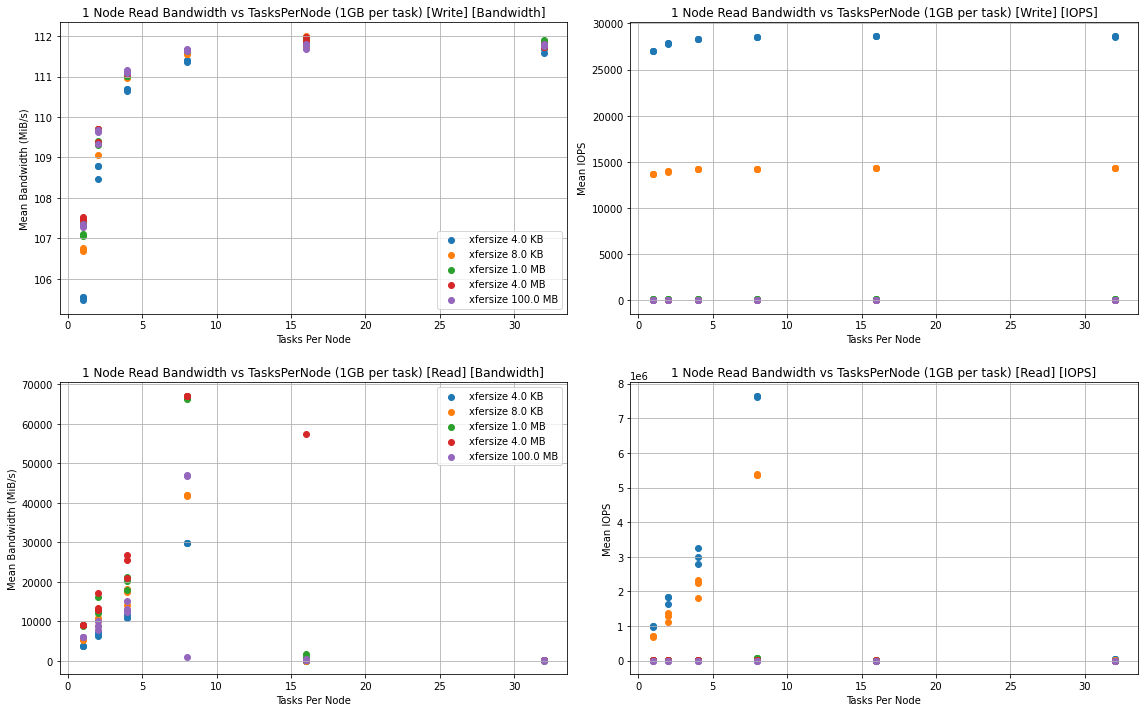

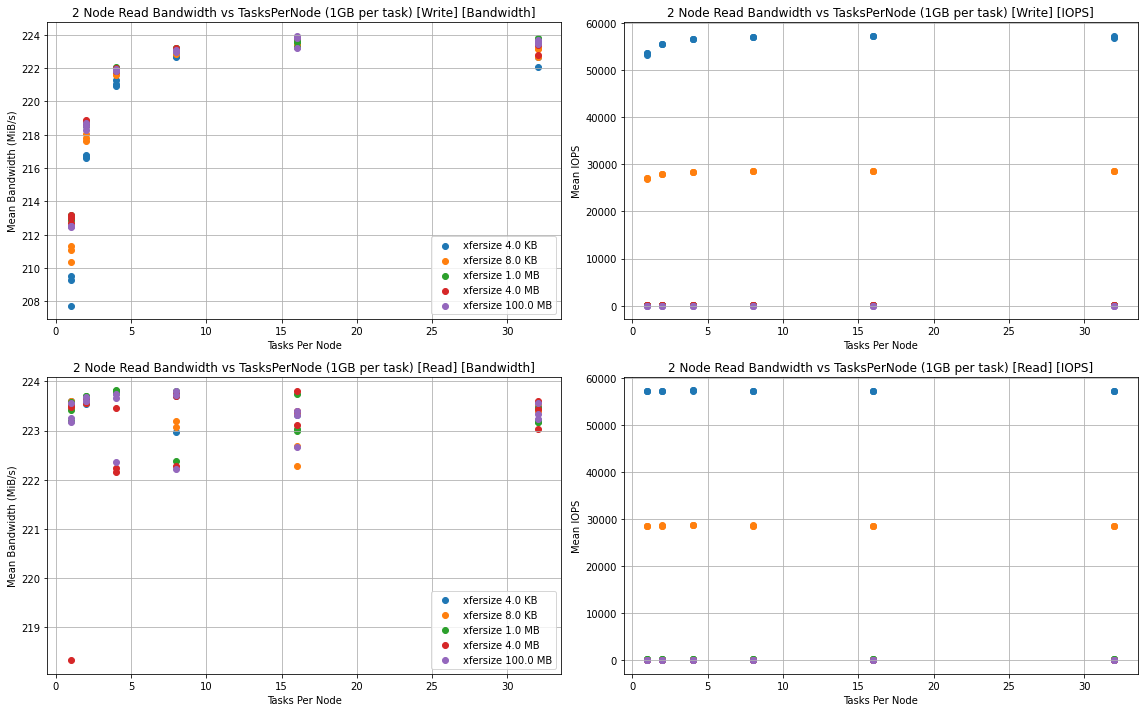

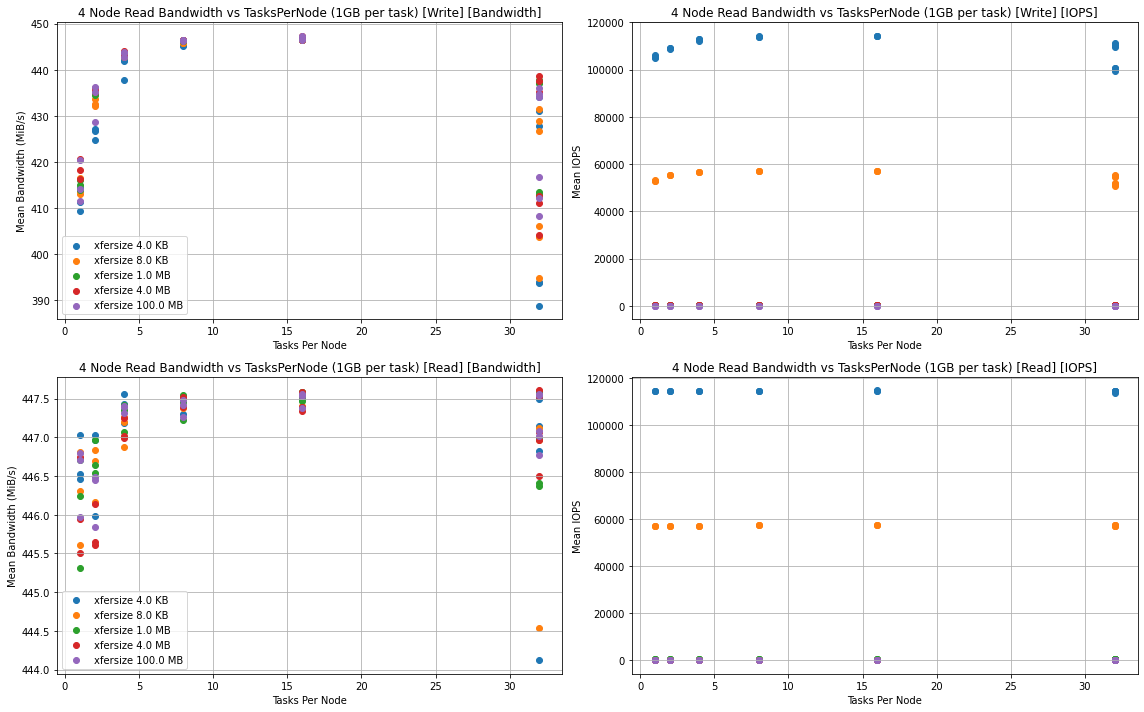

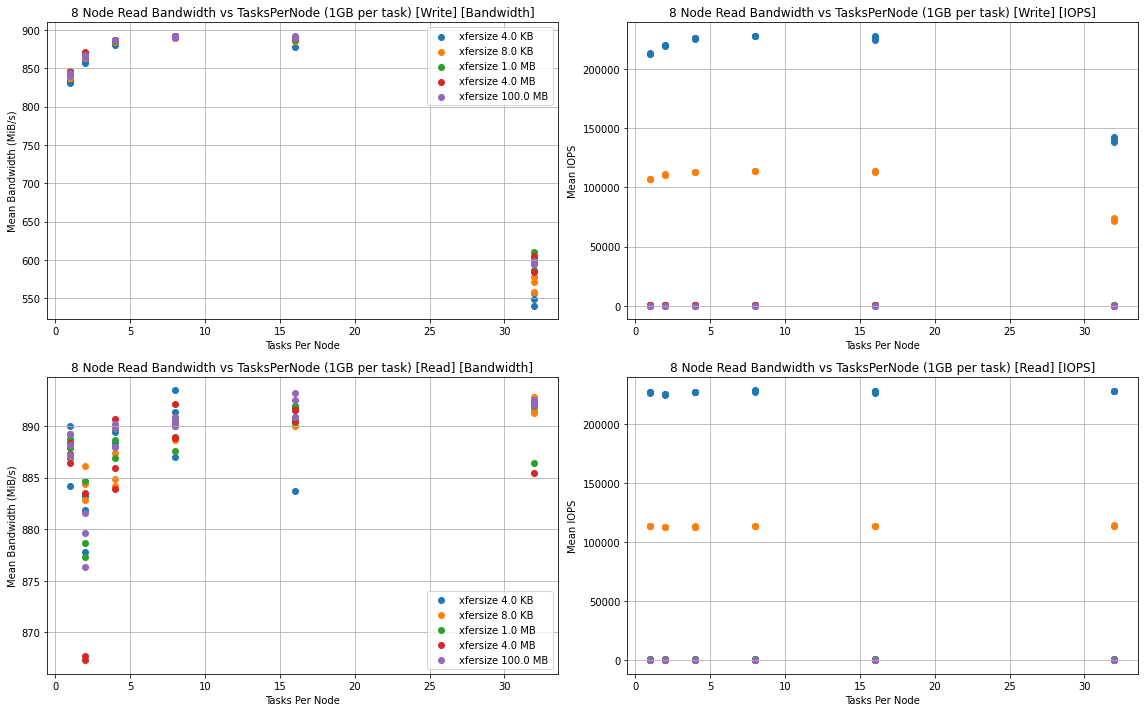

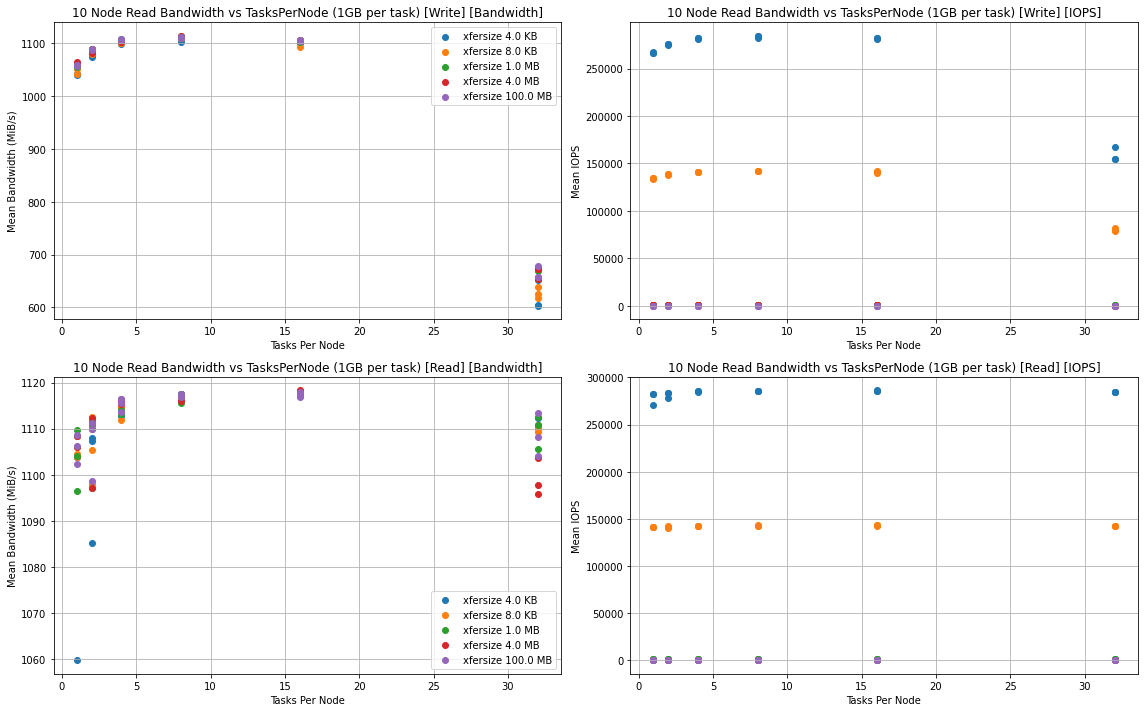

Error loading file: 32_ts4k_bs1000m_t2.json: Expecting value: line 77 column 1 (char 2472)


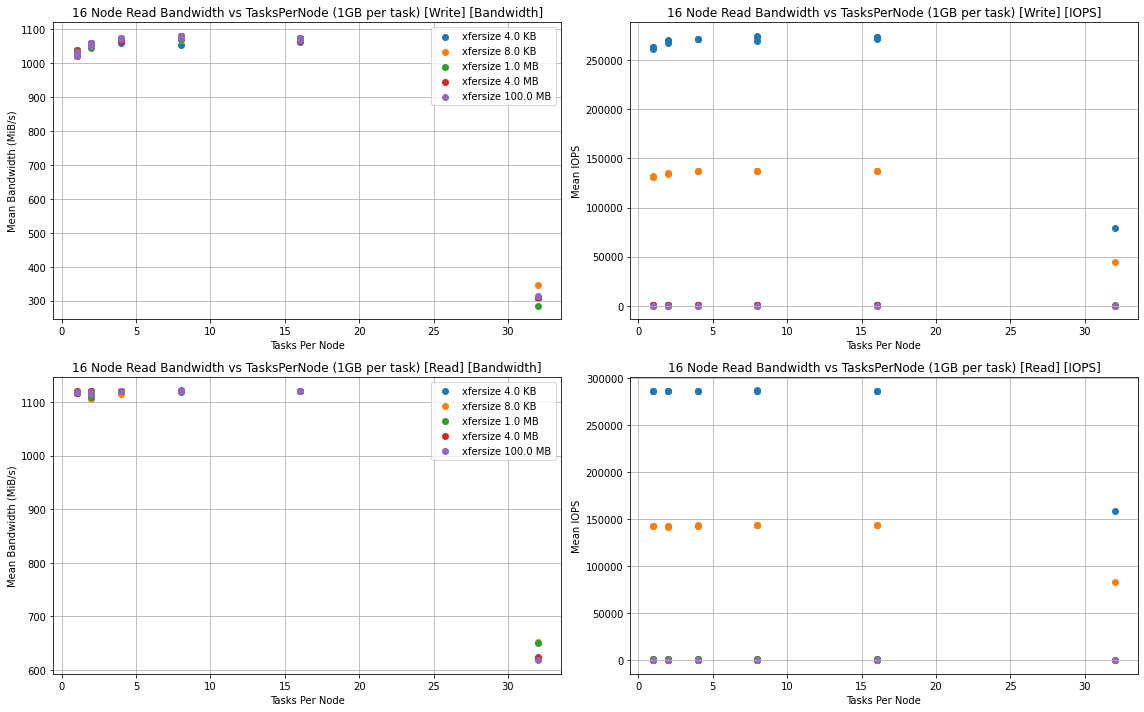

In [21]:
plot_ior_perf(n1_dir, '1 Node Read Bandwidth vs TasksPerNode (1GB per task)')
plot_ior_perf(n2_dir, '2 Node Read Bandwidth vs TasksPerNode (1GB per task)')
plot_ior_perf(n4_dir, '4 Node Read Bandwidth vs TasksPerNode (1GB per task)')
plot_ior_perf(n8_dir, '8 Node Read Bandwidth vs TasksPerNode (1GB per task)')

plot_ior_perf(n10_dir, '10 Node Read Bandwidth vs TasksPerNode (1GB per task)')
plot_ior_perf(n16_dir, '16 Node Read Bandwidth vs TasksPerNode (1GB per task)')

In [22]:
import os
import json
import csv

def format_bytes(num_bytes):
    if num_bytes >= 1024 ** 3:
        return f"{num_bytes / (1024 ** 3):.1f} GB"
    elif num_bytes >= 1024 ** 2:
        return f"{num_bytes / (1024 ** 2):.1f} MB"
    elif num_bytes >= 1024:
        return f"{num_bytes / 1024:.1f} KB"
    else:
        return f"{num_bytes} B"

def find_best_bandwidth_config_split(base_dir, output_prefix):
    """
    Find the single best config separately for write and read,
    print details and save each to its own CSV.
    """
    best_write = None
    best_read = None

    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.json'):
                json_path = os.path.join(root, file)
                try:
                    with open(json_path, 'r') as f:
                        data = json.load(f)
                        if 'summary' in data:
                            for entry in data['summary']:
                                op = entry.get('operation')
                                tasks_per_node = entry.get('tasksPerNode')
                                bw_mean = entry.get('bwMeanMIB')
                                xfersize = entry.get('transferSize')
                                iops = entry.get('OPsMean')

                                if None in (op, tasks_per_node, bw_mean, xfersize, iops):
                                    continue

                                new_entry = {
                                    'operation': op,
                                    'tasksPerNode': tasks_per_node,
                                    'transferSize': xfersize,
                                    'bwMeanMIB': bw_mean,
                                    'iops': iops
                                }

                                if op == 'write':
                                    if best_write is None or bw_mean > best_write['bwMeanMIB']:
                                        best_write = new_entry
                                elif op == 'read':
                                    if best_read is None or bw_mean > best_read['bwMeanMIB']:
                                        best_read = new_entry
                except Exception as e:
                    print(f"Error loading file {file}: {e}")

    # Save & print best write config
    for best_entry, op in [(best_write, 'write'), (best_read, 'read')]:
        if best_entry:
            output_csv = f"{output_prefix}_best_{op}.csv"
            with open(output_csv, mode='w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(['Operation', 'TasksPerNode', 'TransferSize(Bytes)', 'TransferSize(Human)',
                                 'BestBandwidth(MiB/s)', 'IOPS'])
                writer.writerow([
                    best_entry['operation'],
                    best_entry['tasksPerNode'],
                    best_entry['transferSize'],
                    format_bytes(best_entry['transferSize']),
                    f"{best_entry['bwMeanMIB']:.2f}",
                    f"{best_entry['iops']:.2f}"
                ])

            print(f"\nBest {op.upper()} config:")
            print(f"  Operation: {best_entry['operation']}")
            print(f"  TasksPerNode: {best_entry['tasksPerNode']}")
            print(f"  TransferSize: {best_entry['transferSize']} ({format_bytes(best_entry['transferSize'])})")
            print(f"  BestBandwidth(MiB/s): {best_entry['bwMeanMIB']:.2f}")
            print(f"  BestIOPS: {best_entry['iops']:.2f}")
            print(f"  Saved to: {output_csv}")
        else:
            print(f"No valid {op} entries found.")

    print("-----------------------------")



In [23]:
base_root = '/qfs/projects/datamesh/tang584/ERT4IO/aws_fuse_bench'

configs = {
    '1n': '1n_gateway_results_1000bs',
    '2n': '2n_gateway_results_1000bs',
    '4n': '4n_gateway_results_1000bs',
    '8n': '8n_gateway_results_1000bs',
    '10n': '10n_gateway_results_1000bs',
    '16n': '16n_gateway_results_1000bs',
}

for label, subdir in configs.items():
    input_dir = os.path.join(base_root, subdir)
    output_file = f'best_bandwidth_1gb_pertask_{label}'
    find_best_bandwidth_config_split(input_dir, output_file)


Best WRITE config:
  Operation: write
  TasksPerNode: 16
  TransferSize: 8192 (8.0 KB)
  BestBandwidth(MiB/s): 112.01
  BestIOPS: 14337.44
  Saved to: best_bandwidth_1gb_pertask_1n_best_write.csv

Best READ config:
  Operation: read
  TasksPerNode: 8
  TransferSize: 4194304 (4.0 MB)
  BestBandwidth(MiB/s): 67135.05
  BestIOPS: 16783.76
  Saved to: best_bandwidth_1gb_pertask_1n_best_read.csv
-----------------------------

Best WRITE config:
  Operation: write
  TasksPerNode: 16
  TransferSize: 104857600 (100.0 MB)
  BestBandwidth(MiB/s): 223.94
  BestIOPS: 2.24
  Saved to: best_bandwidth_1gb_pertask_2n_best_write.csv

Best READ config:
  Operation: read
  TasksPerNode: 4
  TransferSize: 1048576 (1.0 MB)
  BestBandwidth(MiB/s): 223.81
  BestIOPS: 223.81
  Saved to: best_bandwidth_1gb_pertask_2n_best_read.csv
-----------------------------

Best WRITE config:
  Operation: write
  TasksPerNode: 16
  TransferSize: 4194304 (4.0 MB)
  BestBandwidth(MiB/s): 447.34
  BestIOPS: 111.83
  Saved to

# IOR
- get 

In [ ]:
# import re
# import pandas as pd
# import matplotlib.pyplot as plt

# # Step 1: Read log file
# log_file_path = 'ior_run_summary_6n.log'  # Replace with your actual path
# with open(log_file_path, 'r') as f:
#     log_text = f.read()

# # Step 2: Extract relevant result lines using regex
# pattern = re.compile(
#     r'Result:\s+(?P<test_name>[\w\-]+),\s+TasksPerNode=(?P<tasks_per_node>\d+),\s+XferSize=(?P<xfer_size>\w+),\s+BW=(?P<bandwidth>\d+\.\d+)\s+MB/s'
# )
# matches = pattern.findall(log_text)

# # Step 3: Create DataFrame
# df = pd.DataFrame(matches, columns=['TestName', 'TasksPerNode', 'XferSize', 'Bandwidth'])
# df['TasksPerNode'] = df['TasksPerNode'].astype(int)
# df['Bandwidth'] = df['Bandwidth'].astype(float)

# # Optional: define transfer size order for better sorting
# xfer_order = ['4k', '8k', '1m', '4m', '100m']
# df['XferSize'] = pd.Categorical(df['XferSize'], categories=xfer_order, ordered=True)

# # Step 4: Filter for specific TasksPerNode values
# valid_tasks = [1, 2, 4, 8, 16, 32]
# df = df[df['TasksPerNode'].isin(valid_tasks)]

# # Step 5: Scatter plot
# plt.figure(figsize=(12, 6))
# colors = plt.cm.tab10.colors

# for i, tpn in enumerate(sorted(df['TasksPerNode'].unique())):
#     subset = df[df['TasksPerNode'] == tpn]
#     plt.scatter(subset['XferSize'], subset['Bandwidth'],
#                 label=f'TasksPerNode={tpn}',
#                 color=colors[i % len(colors)],
#                 s=100, alpha=0.7)

# plt.title('IOR Bandwidth on 8 Nodes', fontsize=14)
# plt.xlabel('Transfer Size', fontsize=12)
# plt.ylabel('Bandwidth (MB/s)', fontsize=12)
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.legend(title='TasksPerNode')
# plt.tight_layout()
# plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'ior_run_summary_6n.log'

# file size
- 10GB, 1GB, 1MB, 4KB
    - 4KB 
